# Лабораторная 1

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [3]:
#Подготовка изображений под аугментацию

import os
from PIL import Image, ImageOps

# Функция для добавления белого фона, инвертирования и сохранения изображения
def add_white_background_invert_and_save(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Проходим по всем изображениям в input_dir
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                image = Image.open(img_path)
                
                # Если изображение в RGBA (есть альфа-канал)
                if image.mode == 'RGBA':
                    background = Image.new('RGB', image.size, (255, 255, 255))
                    background.paste(image, (0, 0), image)
                    image = background
                
                # Инвертируем изображение
                inverted_image = ImageOps.invert(image)

                # Сохраняем изображение в output_dir
                output_image_path = os.path.join(output_dir, file)
                inverted_image.save(output_image_path)

In [4]:
#Аугментация

import os
import random
from PIL import Image
from torchvision import transforms

# Определяем набор трансформаций для аугментации
transformations = transforms.Compose([
    transforms.RandomRotation(15),         # Повороты до 15 градусов
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Сдвиги по осям
    #transforms.RandomHorizontalFlip(),     # Горизонтальные отражения
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Изменение яркости/контраста
])

def augment(input_folder, output_folder, augment_factor):
    
    # Для каждого изображения в оригинальном наборе данных
    for filename in os.listdir(input_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Загружаем изображение
            img_path = os.path.join(input_folder, filename)
            image = Image.open(img_path)
    
            # Сохраняем оригинал в папку (если нужно)
            base_name, ext = os.path.splitext(filename)
            original_save_path = os.path.join(output_folder, f"{base_name}_{ext}")
            image.save(original_save_path)
    
            # Генерируем несколько аугментированных изображений
            for i in range(augment_factor):
                augmented_image = transformations(image)  # Применяем трансформации
                augmented_save_path = os.path.join(output_folder, f"{base_name}_{i}{ext}")
                augmented_image.save(augmented_save_path)

In [ ]:
#Обработка

for i in range(1,6):
    input_folder_train = 'data/geroff_dataset/train/' + str(i)
    add_white_background_invert_and_save(input_folder_train, input_folder_train)

    input_folder_test = 'data/geroff_dataset/test/' + str(i)
    add_white_background_invert_and_save(input_folder_test, input_folder_test)


In [ ]:
#Аугмент

# Количество аугментированных изображений на одно оригинальное
augment_factor = 4  # Увеличиваем до 10 изображений на каждое оригинальное

for i in range(1,6):
    input_folder_train = 'data/geroff_dataset/train/' + str(i)
    augment(input_folder_train, input_folder_train,augment_factor)

    input_folder_test = 'data/geroff_dataset/test/' + str(i)
    augment(input_folder_test, input_folder_test,augment_factor)

## Загрузка датасета

In [48]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

# Загрузка данных (train и test)
train_data = datasets.ImageFolder(root='data/geroff_dataset/train', transform=transform_train)
test_data = datasets.ImageFolder(root='data/geroff_dataset/test', transform=transform_test)

# Создание DataLoader для батчевой загрузки данных
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Получим количество классов (например, римские цифры от I до X)
num_classes = len(train_data.classes)
class_names = train_data.classes
print("Классы:", train_data.classes)

Классы: ['1', '2', '3', '4', '5']


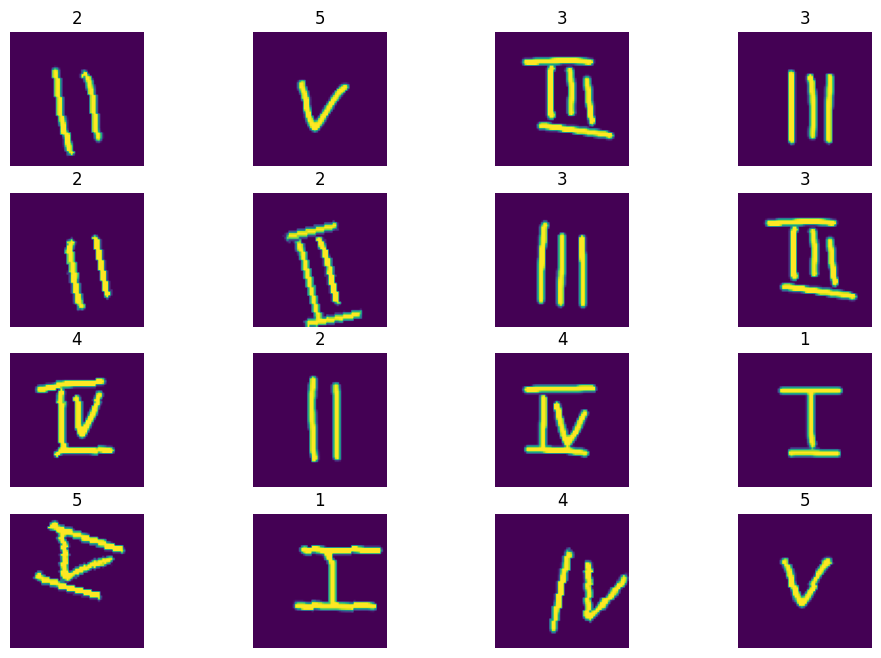

In [49]:
def show_images(images, labels, classes):
    plt.figure(figsize=(12, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(images[i])
        plt.imshow(image)
        actual_class = classes[labels[i]]
        plt.title(f"{actual_class}")
        plt.axis('off')
    plt.show()

for x, y in test_loader:
    show_images(x, y, test_data.classes)
    break

# Модель

In [50]:
class SimpleNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 1, 512)  # Входной слой для 3 каналов (RGB)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(class_names))  # Количество классов

    def forward(self, x):
        x = x.view(-1, 64 * 64 * 1)  # Преобразуем изображения в вектор
        x = torch.relu(self.fc1(x))  # Применяем ReLU
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Последний слой (выходной)
        return x

In [51]:
def train(model, train_loader, loss_function, optimizer, epochs):
    for t in range(epochs):
        print(f"== Epoch {t + 1} ==")
        model.train() # Переключаем сеть в режим обучения

        running_loss = 0.0
        correct = 0
        total = 0

        train_size = len(train_loader.dataset)
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)   # переносим наши данные на девайс
    
            pred = model(x)                 # вычисляем предсказание модели
            loss = loss_function(pred, y)   # вычисляем потери
            loss.backward()                 # запускаем подсчёт градиентов
    
            optimizer.step()                # делаем шаг градиентного спуска
            optimizer.zero_grad()           # обнуляем градиенты
    
            if batch % 100 == 0:
                lossa, current = loss.item(), (batch + 1) * len(x)
                print(f"loss: {lossa:>7f}  [{current:>5d}/{train_size:>5d}]")

            running_loss += loss.item()

            _, predicted = pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
                
        test(model, test_loader, loss_function)

#Функция для вывода статистики на тестовом датасете
def test(model, data_loader, loss_function):
    model.eval() # перевод модели в режим вычислений

    test_size = len(data_loader.dataset)
    num_batches = len(data_loader)
    loss, correct = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= test_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss:>8f} \n")

In [52]:
#Статистика по классам
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Переключаем модель в режим тестирования
    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    class_correct = [0] * 100  # 100 классов для CIFAR-100
    class_total = [0] * 100
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Определяем предсказания модели
            _, predicted = outputs.max(1)
            
            # Считаем количество правильных предсказаний
            correct_predictions += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)
            
            # Считаем точность по каждому классу
            for i in range(labels.size(0)):
                label = labels[i]
                if predicted[i] == label:
                    class_correct[label] += 1
                class_total[label] += 1

    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct_predictions / total_samples
    
    # Вывод точности по каждому классу (опционально)
    for i in range(100):
        if class_total[i] > 0:
            class_accuracy = 100. * class_correct[i] / class_total[i]
            print(f'Class {i}: {class_accuracy:.2f}% accuracy')

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# Запуск, тренировка и тестирование

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

num_classes = 5

# Инициализируем модель
model = SimpleNN(num_classes).to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, train_loader, criterion, optimizer, 10)

evaluate_model(model, test_loader, criterion, device)


Device: cuda
== Epoch 1 ==
loss: 1.603610  [   32/10720]
loss: 0.385804  [ 3232/10720]
loss: 0.506867  [ 6432/10720]
loss: 0.058550  [ 9632/10720]
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.245797 

== Epoch 2 ==
loss: 0.061741  [   32/10720]
loss: 0.073567  [ 3232/10720]
loss: 0.059940  [ 6432/10720]
loss: 0.083126  [ 9632/10720]
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.219479 

== Epoch 3 ==
loss: 0.063429  [   32/10720]
loss: 0.004468  [ 3232/10720]
loss: 0.049378  [ 6432/10720]
loss: 0.005903  [ 9632/10720]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.157726 

== Epoch 4 ==
loss: 0.001755  [   32/10720]
loss: 0.086248  [ 3232/10720]
loss: 0.002098  [ 6432/10720]
loss: 0.026531  [ 9632/10720]
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.255187 

== Epoch 5 ==
loss: 0.005259  [   32/10720]
loss: 0.016104  [ 3232/10720]
loss: 0.007082  [ 6432/10720]
loss: 0.005589  [ 9632/10720]
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.223528 

== Epoch 6 ==
loss: 0.045163  [   32/10720]
loss: 0.02569

(0.10944494126306381, 97.5)

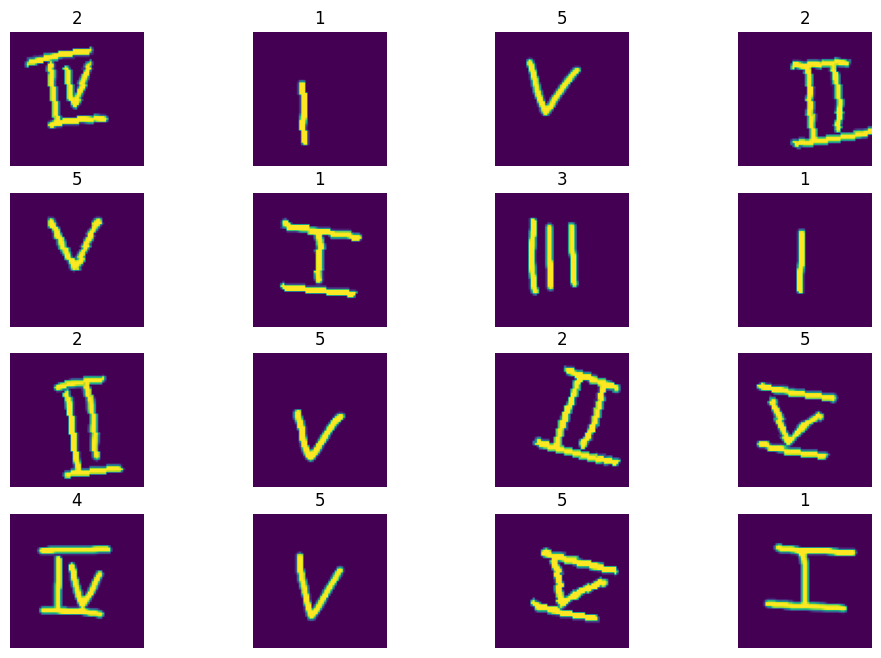

In [54]:
# Основной цикл для получения предсказаний и вывода
for batch_idx, (x, y) in enumerate(test_loader):
    if batch_idx < 1:
        x = x.to(device)  # Перемещаем изображения на устройство модели (GPU/CPU)
        preds = model(x)  # Получаем предсказания модели
        
        # Преобразуем предсказания в метки классов через argmax
        predicted_labels = torch.argmax(preds, dim=1).cpu()  # Индексы предсказанных классов, перемещаем на CPU
        
        # Вызываем функцию отображения с тремя параметрами: изображения, предсказанные метки и классы
        show_images(x, predicted_labels, test_loader.dataset.classes)
        
        break

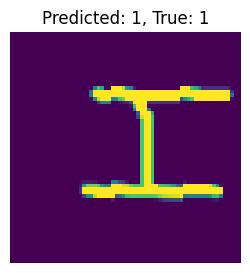

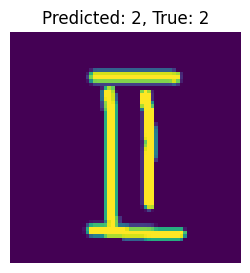

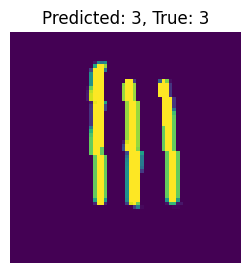

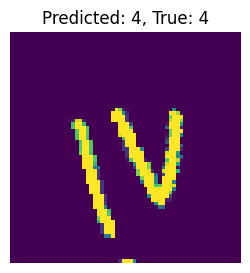

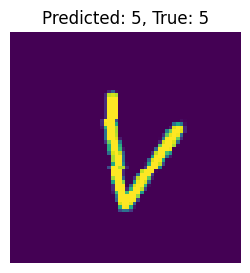

In [55]:
import numpy as np

# Функция для отображения изображения с уменьшенным размером
def imshow(img, title=None, figsize=(5, 5)):
    img = img.numpy().transpose((1, 2, 0))  # Переводим из [C, H, W] в [H, W, C]
    img = np.clip(img, 0, 1)  # Убедимся, что пиксели в диапазоне [0, 1]
    
    plt.figure(figsize=figsize)  # Устанавливаем размер окна
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Функция для вывода 4 случайных изображений (по одному из каждого класса) и вычисления точности
def show_random_images_from_all_classes(model, test_loader, class_names, num_images_per_class=2):
    model.eval()  # Переводим модель в режим оценки (inference)
    
    # Словарь для хранения изображений по каждому классу
    class_images = {class_name: [] for class_name in class_names}
    
    correct_predictions = 0
    total_images = 0
    
    # Перебираем все изображения из test_loader
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Собираем изображения по классу
        for i, label in enumerate(labels):
            class_name = class_names[label.item()]
            class_images[class_name].append((images[i], label))
        
        # Прогоняем изображения через модель и вычисляем точность
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Выбираем случайные изображения из каждого класса
    selected_images = []
    for class_name, images in class_images.items():
        # Выбираем случайное изображение из этого класса
        image, label = random.choice(images)
        selected_images.append((image, label, class_name))
    
    # Прогоняем изображения через модель и отображаем
    for img, label, class_name in selected_images:
        # Получаем предсказание модели
        output = model(img.unsqueeze(0).to(device))  # Добавляем размер batch
        _, predicted = torch.max(output, 1)
        predicted_class_name = class_names[predicted.item()]
        
        # Отображаем изображение с метками
        imshow(img.cpu(), title=f'Predicted: {predicted_class_name}, True: {class_name}', figsize=(3, 3))

# Выводим случайные изображения из каждого класса с их предсказаниями
show_random_images_from_all_classes(model, test_loader, class_names, num_images_per_class=2)

